Получение эмбеддингов из текста и изображений, одновременно тренируем модели

In [1]:
%load_ext autoreload
%autoreload 1
%aimport src.my, src.net, src.data, src.models, src.text_utils

import sys
import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
import importlib
import pickle

# import net, data
import src.text_utils as tu
import src.my as my
from src.my import p
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

dir_data = 'data/'
dir_out = 'out/'
os.makedirs(dir_out, exist_ok=True)

SEED = 34
N_CPU = os.cpu_count()

np.random.seed(SEED)
rng = np.random.default_rng(SEED)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загружаем подготовленные датасеты

In [2]:
Xy = pd.read_parquet(dir_out+'prepared_df.pq')
X_test = pd.read_parquet(dir_out+'prepared_test.pq')
Xy[:2]

,product_id,category_id,shop_id,category_name,fold,text
0,325286,251,493,электроника смартфоны телефоны аксессуары...,4,зарядный кабель borofone bx1 lightning ай...
1,888134,748,6081,одежда женская одежда белье купальники трусы,3,трусы sela трусы слипы эластичного бесшов...


Большая часть описаний товаров состоит из менее чем 200 слов, но f1 была выше когда я брал только 64 первых слова:

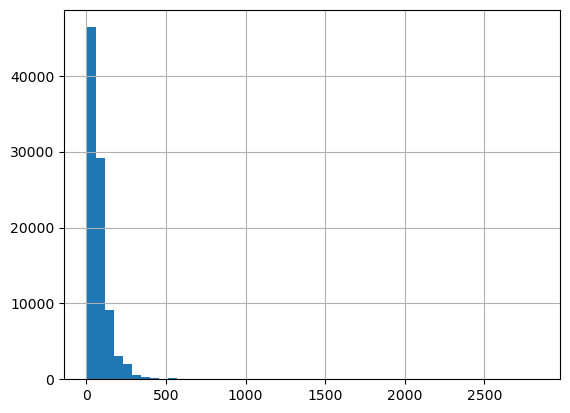

In [4]:
Xy['number_words'] = Xy['text'].apply(tu.number_words)
_ = Xy['number_words'].hist(bins=50)

In [6]:
Xy['number_words'].describe(percentiles=[0.9,0.95,0.98])

count   91120.000
mean       75.143
std        68.724
min         2.000
50%        58.000
90%       146.000
95%       199.000
98%       273.000
max      2834.000
Name: number_words, dtype: float64

Создаем папку bert_model/ в которую будут сохраняться чекпойнты с лучшими скорами и туда же сохраним эмбеддинги полученные от этих моделей для каждого фолда

In [ ]:
# !rm -rf out/bert_model

In [8]:
CHECKPOINT_DIR = dir_out + 'bert_model/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_DIR

'out/bert_model/'

Fine-tunim берт, используя Mixed Precision для увеличения скорости, одна эпоха около 5 мин. Из лучших моделей сохраняем эмбеддинги для всех датасетов функцией data.save_all_embs

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar, ModelCheckpoint
import src.net as net, src.data as data
from pytorch_lightning.plugins.precision import MixedPrecisionPlugin

torch.set_float32_matmul_precision('medium')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class CFG:
    model_name = 'cointegrated/LaBSE-en-ru'
    scheduler='cosine'
    num_cycles=0.5
    num_warmup_steps=30
    epochs=30
    batch_size=128
    max_length = 64
    gradient_checkpointing=False
    gradient_accumulation_steps=1
    max_grad_norm=50
    precision = 16

def train_fold(Xy:pd.DataFrame, Xy_test:pd.DataFrame, fold:int=0):
    print('[TRAIN FOLD]:',fold)
    net.set_seed(SEED + 10*fold)
    NAME_CKPT = f'best_f{fold}'

    dm = data.BertDataModule(Xy, Xy_test, fold=fold, batch_size = CFG.batch_size, n_cpu=3, cfg=CFG)

    CFG.num_train_steps = int(dm.len_train/CFG.batch_size*CFG.epochs)

    model = net.BertModule(CFG, lr = 5e-5)

    tq = TQDMProgressBar(refresh_rate=5)

    es = EarlyStopping('val_f1', min_delta=0.001,patience=5,verbose=True, mode='max', check_on_train_epoch_end=False)

    chpt = ModelCheckpoint(dirpath=CHECKPOINT_DIR,filename=f'best_f{fold}',  monitor='val_f1',mode='max')

    trainer = pl.Trainer(
        precision=CFG.precision,
        plugins=[MixedPrecisionPlugin(precision=16,device='cuda')],
    callbacks=[tq,es,chpt],
    max_epochs=CFG.epochs,
    deterministic = True,
    accelerator='auto',
    accumulate_grad_batches = CFG.gradient_accumulation_steps,
    gradient_clip_val = CFG.max_grad_norm,
    log_every_n_steps = 50,
    enable_model_summary = True if fold==0 else False,
    # val_check_interval = 1.,
#         auto_lr_find=True
    )
    trainer.fit(model, datamodule=dm)

    del trainer
    torch.cuda.empty_cache()
    gc.collect()

    model = net.BertModule.load_from_checkpoint(checkpoint_path=chpt.best_model_path).to(net.device)

    data.save_all_embs(model, dm, prefix='bert',dir_out= CHECKPOINT_DIR)

    return chpt.best_model_score.cpu().item()

res = []
for fold in sorted(Xy['fold'].unique()):
    res_fold = train_fold(Xy, X_test, fold=fold)
    res.append((fold,res_fold))

Так как логов много, я их удалил, в цикле ниже выполняется валидация еще раз и предсказание на тестовом датасете для final submit

In [ ]:
scores = []
preds = []

for fold in sorted(Xy['fold'].unique()):
    dm = data.BertDataModule(Xy, X_test, fold=fold, batch_size = CFG.batch_size, n_cpu=3, cfg=CFG)
    dm.setup('fit')

    model = net.BertModule.load_from_checkpoint(checkpoint_path=CHECKPOINT_DIR+f'best_f{fold}.ckpt').to(net.device)
    model.eval()

    trainer = pl.Trainer(accelerator='gpu', devices=1)

    score = trainer.validate(model, dm)
    scores.append((fold,score[0]['val_f1']))

    fold_test_pred = trainer.predict(model, dm)
    preds.append(torch.cat(fold_test_pred))

scores = pd.DataFrame(scores, columns=['fold', 'val_f1'])

In [28]:
scores

,fold,val_f1
0,0,0.883
1,1,0.891
2,2,0.887
3,3,0.881
4,4,0.880


Усредняем предсказания по фолдам

In [36]:
mean_fold_preds = torch.mean(torch.stack(preds), dim=0)
mean_fold_preds.shape

torch.Size([16860, 874])

In [37]:
categories = torch.argmax(mean_fold_preds, dim = 1)
categories

tensor([573, 831,  70,  ..., 610,  19, 156])

In [49]:
submission = X_test[['product_id']].copy()
submission['predicted_category_id'] = categories.numpy()
encoders = my.load_pickle(dir_out+'encoders.pik')
submission['predicted_category_id'] = encoders['cat_enc'].inverse_transform(submission['predicted_category_id'])
submission

,product_id,predicted_category_id
0,1997646,13495
1,927375,14922
2,1921513,2803
3,1668662,13755
4,1467778,13887
...,...,...
16855,1914264,11645
16856,1310569,12357
16857,978095,13651
16858,797547,2740


In [50]:
submission.to_parquet('result.parquet',index=False)

Fine-tunim EfficientNet, замораживая первые 3 слоя, используя аугментации. Эпоха около 4 мин. Из лучших моделей сохраняем эмбеддинги для всех датасетов функцией data.save_all_embs

In [3]:
CHECKPOINT_DIR = dir_out + 'image_model/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_DIR

'out/image_model/'

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar, ModelCheckpoint
import src.net as net, src.data as data

torch.set_float32_matmul_precision('medium')

def train_fold(Xy:pd.DataFrame, Xy_test:pd.DataFrame, fold:int=0):
    print('[TRAIN FOLD]:',fold)
    net.set_seed(SEED + 10*fold)
    NAME_CKPT = f'best_f{fold}'

    dm = data.ImageDataModule(Xy, Xy_test, fold=fold, batch_size=196)

    model = net.ImageModule(lr = 0.001,freeze_first_layers=3)

    tq = TQDMProgressBar(refresh_rate=5)

    es = EarlyStopping('val_f1', min_delta=0.001,patience=6, verbose=True, mode='max', check_on_train_epoch_end=False)

    chpt = ModelCheckpoint(dirpath=CHECKPOINT_DIR,filename=f'best_f{fold}',  monitor='val_f1',mode='max')

    trainer = pl.Trainer(
    callbacks=[tq,es,chpt],
    max_epochs=500,
    deterministic = True,
    accelerator='auto',
    log_every_n_steps = 50,
    enable_model_summary = True if fold==0 else False,
    # val_check_interval = 1.,
#         auto_lr_find=True
    )
    trainer.fit(model, datamodule=dm) # ckpt_path =

    del trainer, model
    torch.cuda.empty_cache()
    gc.collect()

    model = net.ImageModule.load_from_checkpoint(checkpoint_path=chpt.best_model_path).to(net.device)

    data.save_all_embs(model, dm, prefix='img',dir_out= CHECKPOINT_DIR)

    return chpt.best_model_score.cpu().item()

res = []
for fold in sorted(Xy['fold'].unique()):
    res_fold = train_fold(Xy, X_test, fold=fold)
    res.append((fold,res_fold))
    break

In [ ]:
scores = []

for fold in sorted(Xy['fold'].unique()):
    dm = data.ImageDataModule(Xy, X_test, fold=fold, batch_size=196)
    dm.setup('fit')

    model = net.ImageModule.load_from_checkpoint(checkpoint_path=CHECKPOINT_DIR+f'best_f{fold}.ckpt').to(net.device)
    model.eval()

    trainer = pl.Trainer(accelerator='gpu', devices=1)

    score = trainer.validate(model, dm)
    scores.append((fold,score[0]['val_f1']))

scores = pd.DataFrame(scores, columns=['fold', 'val_f1'])

In [11]:
scores

,fold,val_f1
0,0,0.613
1,1,0.637
2,2,0.636
3,3,0.635
4,4,0.630
